# SALMA LIDAE 
# Class : SDIA -- TP1 : RNN

# TP CI4 : Réseaux Récurrents - Génération de Musique ABC

In [22]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
import os

# 1. dataset : ABC music

In [23]:
splits = {'train': 'train.json', 'validation': 'validation.json'}
train_data = pd.read_json("hf://datasets/sander-wood/irishman/" + splits["train"])
val_data = pd.read_json("hf://datasets/sander-wood/irishman/" + splits["validation"])

print(f"\nNombre de chansons dans le train set: {len(train_data)}")
print(f"Nombre de chansons dans le validation set: {len(val_data)}")


Nombre de chansons dans le train set: 214122
Nombre de chansons dans le validation set: 2162


In [24]:
print(f"\nPremière chanson du train set:")
print(train_data['abc notation'].iloc[0][:200])


Première chanson du train set:
X:1
L:1/8
M:4/4
K:Emin
|: E2 EF E2 EF | DEFG AFDF | E2 EF E2 B2 |1 efe^d e2 e2 :|2 efe^d e3 B |: e2 ef g2 fe | 
 defg afdf |1 e2 ef g2 fe | efe^d e3 B :|2 g2 bg f2 af | efe^d e2 e2 ||


# 2. Extraction des caractères uniques

In [25]:
def extract_unique_chars(data):
    """Extrait tous les caractères uniques du dataset"""
    all_text = ''.join(data['abc notation'].tolist())
    unique_chars = sorted(list(set(all_text)))
    return unique_chars

In [26]:
unique_chars = extract_unique_chars(train_data)
vocab_size = len(unique_chars)
print(f"\nNombre de caractères uniques: {vocab_size}")
print(f"Caractères uniques: {unique_chars[:20]}...")


Nombre de caractères uniques: 95
Caractères uniques: ['\n', ' ', '!', '"', '#', '$', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3']...


# 3. Mapping caractères-index


In [27]:
char_to_idx = {char: idx for idx, char in enumerate(unique_chars)}
idx_to_char = {idx: char for idx, char in enumerate(unique_chars)}

In [28]:
print(f"\nExemple de mapping (premiers 5):")
for i, char in enumerate(unique_chars[:5]):
    print(f"  '{char}' -> {char_to_idx[char]}")


Exemple de mapping (premiers 5):
  '
' -> 0
  ' ' -> 1
  '!' -> 2
  '"' -> 3
  '#' -> 4


# 4. Vectorisation des chaînes


In [29]:
def vectorize_string(text, char_to_idx):
    """Convertit une chaîne en liste d'indices"""
    return [char_to_idx[char] for char in text]
test_text = train_data['abc notation'].iloc[0][:20]
vectorized = vectorize_string(test_text, char_to_idx)
print(f"\nTest de vectorisation:")
print(f"Texte: {test_text}")
print(f"Indices: {vectorized}")


Test de vectorisation:
Texte: X:1
L:1/8
M:4/4
K:Em
Indices: [56, 26, 17, 0, 44, 26, 17, 15, 24, 0, 45, 26, 20, 15, 20, 0, 43, 26, 37, 77]


# 5. Padding des séquences


In [30]:
def find_max_length(data):
    """Trouve la longueur maximale des séquences"""
    return data['abc notation'].str.len().max()

max_length = find_max_length(train_data)
print(f"\nLongueur maximale des séquences: {max_length}")

# Afficher les statistiques de longueur
lengths = train_data['abc notation'].str.len()
print(f"\nStatistiques des longueurs:")
print(f"  Min: {lengths.min()}")
print(f"  Médiane: {lengths.median():.0f}")
print(f"  Moyenne: {lengths.mean():.0f}")
print(f"  95e percentile: {lengths.quantile(0.95):.0f}")
print(f"  Max: {lengths.max()}")


Longueur maximale des séquences: 2968

Statistiques des longueurs:
  Min: 22
  Médiane: 257
  Moyenne: 290
  95e percentile: 548
  Max: 2968


In [31]:
def pad_or_truncate(text, max_length, pad_char=' '):
    """Ajoute du padding ou tronque une séquence"""
    if len(text) < max_length:
        return text + pad_char * (max_length - len(text))
    else:
        return text[:max_length]



# Test de padding
test_padded = pad_or_truncate("ABC", 10)
print(f"\nTest de padding: 'ABC' -> '{test_padded}' (longueur: {len(test_padded)})")


Test de padding: 'ABC' -> 'ABC       ' (longueur: 10)


# 6. CRÉATION DU DATASET PYTORCH


In [18]:
def prepare_data(data, char_to_idx, max_length):
    """Prépare les données: vectorisation et padding"""
    sequences = []
    for idx in range(len(data)):
        text = data['abc notation'].iloc[idx]
        text_padded = pad_or_truncate(text, max_length)
        vectorized = vectorize_string(text_padded, char_to_idx)
        sequences.append(vectorized)
    return torch.LongTensor(sequences)



class MusicDataset(Dataset):
    """Dataset PyTorch pour les séquences musicales"""
    
    def __init__(self, sequences):
        """
        Args:
            sequences: Tensor de shape (num_sequences, seq_length)
        """
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        """
        Retourne:
            input_seq: séquence d'entrée (tout sauf le dernier caractère)
            target_seq: séquence cible (tout sauf le premier caractère)
        """
        sequence = self.sequences[idx]
        input_seq = sequence[:-1]  # Tout sauf le dernier
        target_seq = sequence[1:]  # Tout sauf le premier
        return input_seq, target_seq

In [32]:
# Préparer les données
print("\nPréparation des données (cela peut prendre quelques minutes)...")
train_sequences = prepare_data(train_data, char_to_idx, max_length)
val_sequences = prepare_data(val_data, char_to_idx, max_length)

print(f"Shape des séquences d'entraînement: {train_sequences.shape}")
print(f"Shape des séquences de validation: {val_sequences.shape}")



Préparation des données (cela peut prendre quelques minutes)...
Shape des séquences d'entraînement: torch.Size([214122, 2968])
Shape des séquences de validation: torch.Size([2162, 2968])


In [33]:
train_dataset = MusicDataset(train_sequences)
val_dataset = MusicDataset(val_sequences)

batch_size = 8 
train_loader = DataLoader(train_dataset, batch_size=batch_size,drop_last=True
,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Vérifier un batch
print(f"\nVérification d'un batch:")
for inputs, targets in train_loader:
    print(f"  Shape des inputs: {inputs.shape}")
    print(f"  Shape des targets: {targets.shape}")
    print(f"  Premier exemple (5 premiers caractères):")
    print(f"    Input: {inputs[0, :5].tolist()}")
    print(f"    Target: {targets[0, :5].tolist()}")
    break


Vérification d'un batch:
  Shape des inputs: torch.Size([8, 2967])
  Shape des targets: torch.Size([8, 2967])
  Premier exemple (5 premiers caractères):
    Input: [56, 26, 17, 25, 16]
    Target: [26, 17, 25, 16, 19]


# 7. IMPLÉMENTATION DU MODÈLE


In [34]:
class MusicRNN(nn.Module):    
    def __init__(self, vocab_size, embedding_dim, hidden_size, num_layers=2, dropout=0.3):
        super(MusicRNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Couche d'embedding
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_size, 
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True)
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, x, hidden=None):
        # Embedding
        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)
        
        # LSTM
        if hidden is None:
            lstm_out, hidden = self.lstm(embedded)
        else:
            lstm_out, hidden = self.lstm(embedded, hidden)
        
        # Dropout
        lstm_out = self.dropout(lstm_out)
        
        # Couche de sortie
        output = self.fc(lstm_out)  # (batch_size, seq_length, vocab_size)
        
        return output, hidden
    
    def init_hidden(self, batch_size, device):
        """Initialise l'état caché"""
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return (h0, c0)

In [35]:
# Test du modèle
embedding_dim = 256
hidden_size = 512
model = MusicRNN(vocab_size, embedding_dim, hidden_size)
print(f"\nModèle créé:")
print(f"  Paramètres totaux: {sum(p.numel() for p in model.parameters()):,}")
print(f"\nArchitecture:")
print(model)


Modèle créé:
  Paramètres totaux: 3,751,263

Architecture:
MusicRNN(
  (embedding): Embedding(95, 256)
  (lstm): LSTM(256, 512, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=95, bias=True)
)


# 8. BOUCLE D'ENTRAÎNEMENT


In [36]:
def calculate_accuracy(outputs, targets):
    """Calcule l'accuracy"""
    _, predicted = torch.max(outputs, dim=-1)
    correct = (predicted == targets).float()
    accuracy = correct.sum() / correct.numel()
    return accuracy.item()

In [37]:
def train_model(model, train_loader, val_loader, num_epochs, learning_rate, 
                device, patience=5, save_path='best_model.pth'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # TensorBoard
    writer = SummaryWriter('runs/music_rnn')
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_acc = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for inputs, targets in pbar:
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Forward
            optimizer.zero_grad()
            outputs, _ = model(inputs)
            
            # Reshape pour calculer la loss
            outputs_flat = outputs.view(-1, vocab_size)
            targets_flat = targets.view(-1)
            
            loss = criterion(outputs_flat, targets_flat)
            
            # Backward
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            
            # Métriques
            train_loss += loss.item()
            train_acc += calculate_accuracy(outputs_flat, targets_flat)
            
            pbar.set_postfix({'loss': loss.item()})
        
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        
        model.eval()
        val_loss = 0
        val_acc = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                outputs, _ = model(inputs)
                
                outputs_flat = outputs.view(-1, vocab_size)
                targets_flat = targets.view(-1)
                
                loss = criterion(outputs_flat, targets_flat)
                
                val_loss += loss.item()
                val_acc += calculate_accuracy(outputs_flat, targets_flat)
        
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        
        # Logging
        print(f'\nÉpoque {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
        
        writer.add_scalars('Loss', {'train': train_loss, 'val': val_loss}, epoch)
        writer.add_scalars('Accuracy', {'train': train_acc, 'val': val_acc}, epoch)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), save_path)
            print(f'  ✓ Meilleur modèle sauvegardé!')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'\nEarly stopping après {epoch+1} époques')
                break
    
    writer.close()
    print(f'\nEntraînement terminé. Meilleur modèle sauvegardé dans {save_path}')

In [38]:
# Configuration de l'entraînement
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nDevice utilisé: {device}")

# Hyperparamètres du TP
num_training_iterations = 3000
batch_size_train = 64
learning_rate = 5e-3
embedding_dim = 256
hidden_size = 1024


Device utilisé: cuda


In [39]:
# Recréer les dataloaders avec le bon batch_size
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size_train, shuffle=False, num_workers=4)

model = MusicRNN(vocab_size, embedding_dim, hidden_size)

train_model(model, train_loader, val_loader, num_training_iterations, learning_rate, device, patience=10)

Epoch 1/3000:   1%|          | 30/3346 [01:20<2:28:19,  2.68s/it, loss=0.334]


KeyboardInterrupt: 

### 3000 epoch is too much and we dont have enough GPU time to run it -- i will change the parameters for a quick training : 

# 9. Changement des hyperparametres pour un entrainement rapide

In [43]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

embedding_dim = 256        
hidden_size = 768          
num_layers = 3      
dropout = 0.3           

# 2. BETTER OPTIMIZER SETTINGS
learning_rate = 5e-4       # Lower, more stable
weight_decay = 1e-5        # L2 regularization

# 3. LEARNING RATE SCHEDULER
model = MusicRNN(vocab_size, embedding_dim, hidden_size, 
                 num_layers=num_layers, dropout=dropout)
model = model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, 
                        weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                              patience=2, verbose=True)

num_epochs = 35 





def train_model_improved(model, train_loader, val_loader, num_epochs, 
                        optimizer, scheduler, device, patience=7, 
                        save_path='best_model.pth'):
    criterion = nn.CrossEntropyLoss()
    writer = SummaryWriter('runs/music_rnn_improved')
    
    best_val_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # TRAINING
        model.train()
        train_loss = 0
        train_acc = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs, _ = model(inputs)
            
            outputs_flat = outputs.view(-1, vocab_size)
            targets_flat = targets.view(-1)
            
            loss = criterion(outputs_flat, targets_flat)
            loss.backward()
            
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            train_acc += calculate_accuracy(outputs_flat, targets_flat)
            pbar.set_postfix({'loss': f'{loss.item():.3f}'})
        
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        
        # VALIDATION
        model.eval()
        val_loss = 0
        val_acc = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs, _ = model(inputs)
                
                outputs_flat = outputs.view(-1, vocab_size)
                targets_flat = targets.view(-1)
                
                loss = criterion(outputs_flat, targets_flat)
                val_loss += loss.item()
                val_acc += calculate_accuracy(outputs_flat, targets_flat)
        
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        
        # SCHEDULER STEP
        scheduler.step(val_loss)
        
        # LOGGING
        print(f'\nÉpoque {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
        print(f'  LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        writer.add_scalars('Loss', {'train': train_loss, 'val': val_loss}, epoch)
        writer.add_scalars('Accuracy', {'train': train_acc, 'val': val_acc}, epoch)
        writer.add_scalar('Learning_Rate', optimizer.param_groups[0]['lr'], epoch)
        
        # EARLY STOPPING & SAVE
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_acc': val_acc,
            }, save_path)
            print(f'  ✓ Meilleur modèle sauvegardé! (Val Acc: {val_acc:.4f})')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'\nEarly stopping après {epoch+1} époques')
                break
    
    writer.close()
    return model


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


# 10. TEMPERATURE SAMPLING pour la Generation


In [ ]:
def generate_music(model, start_string, length, char_to_idx, idx_to_char, 
                   device, temperature=0.8, top_k=10):
    """
    Generate music with improved sampling
    
    Args:
        temperature: Controls randomness (0.5=conservative, 1.0=balanced, 1.5=creative)
        top_k: Sample from top k predictions (reduces gibberish)
    """
    model.eval()
    model = model.to(device)
    
    # Validate start string
    input_indices = []
    for c in start_string:
        if c in char_to_idx:
            input_indices.append(char_to_idx[c])
        else:
            print(f"Warning: Character '{c}' not in vocabulary, skipping")
    
    if not input_indices:
        raise ValueError("No valid characters in start_string")
    
    input_tensor = torch.LongTensor([input_indices]).to(device)
    generated = start_string
    hidden = None
    
    with torch.no_grad():
        # Process seed string
        output, hidden = model(input_tensor, hidden)
        
        # Generate character by character
        for i in range(length):
            # Get last prediction
            last_output = output[0, -1, :] / temperature
            
            # Top-k sampling (optional)
            if top_k > 0:
                top_k_values, top_k_indices = torch.topk(last_output, top_k)
                probs = torch.softmax(top_k_values, dim=0)
                next_idx_in_topk = torch.multinomial(probs, 1).item()
                next_idx = top_k_indices[next_idx_in_topk].item()
            else:
                probs = torch.softmax(last_output, dim=0)
                next_idx = torch.multinomial(probs, 1).item()
            
            next_char = idx_to_char[next_idx]
            generated += next_char
            
            # Next iteration
            input_tensor = torch.LongTensor([[next_idx]]).to(device)
            output, hidden = model(input_tensor, hidden)
    
    return generated

In [ ]:
# GENERATE MULTIPLE TUNES WITH DIFFERENT SETTINGS

def generate_multiple_tunes(model, char_to_idx, idx_to_char, device):
    """Generate several tunes with different parameters"""
    
    # Common ABC notation start strings
    start_strings = [
        "X:1\nL:1/8\nM:4/4\nK:G\n",
        "X:1\nL:1/8\nM:6/8\nK:D\n",
        "X:1\nL:1/8\nM:4/4\nK:Em\n",
    ]
    
    temperatures = [0.6, 0.8, 1.0]
    
    generated_tunes = []
    
    for i, (start, temp) in enumerate(zip(start_strings, temperatures)):
        print(f"\n{'='*60}")
        print(f"TUNE {i+1} (Temperature: {temp})")
        print(f"{'='*60}")
        
        tune = generate_music(
            model, 
            start_string=start,
            length=400,  # Generate ~400 characters
            char_to_idx=char_to_idx,
            idx_to_char=idx_to_char,
            device=device,
            temperature=temp,
            top_k=10
        )
        
        print(tune)
        generated_tunes.append(tune)
        
        # Save to file
        with open(f'generated_tune_{i+1}.abc', 'w') as f:
            f.write(tune)
    
    return generated_tunes

In [44]:
# LOAD MODEL AND GENERATE

def load_and_generate():
    """Load best model and generate music"""
    
    # Load model
    print("Loading best model...")
    checkpoint = torch.load('best_model.pth')
    
    model = MusicRNN(vocab_size, embedding_dim, hidden_size, 
                     num_layers=num_layers, dropout=dropout)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    print(f"Model loaded! Val Accuracy: {checkpoint['val_acc']:.4f}")
    
    # Generate tunes
    tunes = generate_multiple_tunes(model, char_to_idx, idx_to_char, device)
    
    return model, tunes



In [45]:
train_model_improved(model, train_loader, val_loader, num_epochs=35,
                     optimizer=optimizer, scheduler=scheduler, device=device)

model, tunes = load_and_generate()

Epoch 1/35: 100%|██████████| 157/157 [02:27<00:00,  1.06it/s, loss=0.837]



Époque 1/35
  Train Loss: 1.3055 | Train Acc: 0.6912
  Val Loss: 0.8032 | Val Acc: 0.7614
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.7614)


Epoch 2/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.655]



Époque 2/35
  Train Loss: 0.7228 | Train Acc: 0.7750
  Val Loss: 0.6463 | Val Acc: 0.7937
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.7937)


Epoch 3/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.564]



Époque 3/35
  Train Loss: 0.6333 | Train Acc: 0.7974
  Val Loss: 0.5863 | Val Acc: 0.8144
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.8144)


Epoch 4/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.555]



Époque 4/35
  Train Loss: 0.5810 | Train Acc: 0.8141
  Val Loss: 0.5431 | Val Acc: 0.8270
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.8270)


Epoch 5/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.496]



Époque 5/35
  Train Loss: 0.5449 | Train Acc: 0.8252
  Val Loss: 0.5172 | Val Acc: 0.8356
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.8356)


Epoch 6/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.518]



Époque 6/35
  Train Loss: 0.5192 | Train Acc: 0.8328
  Val Loss: 0.4935 | Val Acc: 0.8420
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.8420)


Epoch 7/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.544]



Époque 7/35
  Train Loss: 0.5006 | Train Acc: 0.8384
  Val Loss: 0.4811 | Val Acc: 0.8456
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.8456)


Epoch 8/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.455]



Époque 8/35
  Train Loss: 0.4856 | Train Acc: 0.8427
  Val Loss: 0.4690 | Val Acc: 0.8491
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.8491)


Epoch 9/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.478]



Époque 9/35
  Train Loss: 0.4735 | Train Acc: 0.8462
  Val Loss: 0.4607 | Val Acc: 0.8516
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.8516)


Epoch 10/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.433]



Époque 10/35
  Train Loss: 0.4625 | Train Acc: 0.8495
  Val Loss: 0.4502 | Val Acc: 0.8547
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.8547)


Epoch 11/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.454]



Époque 11/35
  Train Loss: 0.4523 | Train Acc: 0.8525
  Val Loss: 0.4414 | Val Acc: 0.8574
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.8574)


Epoch 12/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.405]



Époque 12/35
  Train Loss: 0.4425 | Train Acc: 0.8555
  Val Loss: 0.4359 | Val Acc: 0.8592
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.8592)


Epoch 13/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.420]



Époque 13/35
  Train Loss: 0.4336 | Train Acc: 0.8583
  Val Loss: 0.4299 | Val Acc: 0.8610
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.8610)


Epoch 14/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.424]



Époque 14/35
  Train Loss: 0.4276 | Train Acc: 0.8601
  Val Loss: 0.4252 | Val Acc: 0.8624
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.8624)


Epoch 15/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.446]



Époque 15/35
  Train Loss: 0.4196 | Train Acc: 0.8625
  Val Loss: 0.4216 | Val Acc: 0.8635
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.8635)


Epoch 16/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.396]



Époque 16/35
  Train Loss: 0.4116 | Train Acc: 0.8651
  Val Loss: 0.4188 | Val Acc: 0.8646
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.8646)


Epoch 17/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.407]



Époque 17/35
  Train Loss: 0.4052 | Train Acc: 0.8671
  Val Loss: 0.4145 | Val Acc: 0.8662
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.8662)


Epoch 18/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.392]



Époque 18/35
  Train Loss: 0.3992 | Train Acc: 0.8689
  Val Loss: 0.4108 | Val Acc: 0.8673
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.8673)


Epoch 19/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.453]



Époque 19/35
  Train Loss: 0.3939 | Train Acc: 0.8706
  Val Loss: 0.4091 | Val Acc: 0.8676
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.8676)


Epoch 20/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.397]



Époque 20/35
  Train Loss: 0.3926 | Train Acc: 0.8709
  Val Loss: 0.4074 | Val Acc: 0.8684
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.8684)


Epoch 21/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.352]



Époque 21/35
  Train Loss: 0.3827 | Train Acc: 0.8741
  Val Loss: 0.4047 | Val Acc: 0.8693
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.8693)


Epoch 22/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.356]



Époque 22/35
  Train Loss: 0.3763 | Train Acc: 0.8761
  Val Loss: 0.4036 | Val Acc: 0.8698
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.8698)


Epoch 23/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.364]



Époque 23/35
  Train Loss: 0.3711 | Train Acc: 0.8777
  Val Loss: 0.4032 | Val Acc: 0.8702
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.8702)


Epoch 24/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.386]



Époque 24/35
  Train Loss: 0.3658 | Train Acc: 0.8794
  Val Loss: 0.4025 | Val Acc: 0.8708
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.8708)


Epoch 25/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.315]



Époque 25/35
  Train Loss: 0.3606 | Train Acc: 0.8810
  Val Loss: 0.4026 | Val Acc: 0.8714
  LR: 0.000500


Epoch 26/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.332]



Époque 26/35
  Train Loss: 0.3553 | Train Acc: 0.8827
  Val Loss: 0.4010 | Val Acc: 0.8713
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.8713)


Epoch 27/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.359]



Époque 27/35
  Train Loss: 0.3503 | Train Acc: 0.8843
  Val Loss: 0.4004 | Val Acc: 0.8719
  LR: 0.000500
  ✓ Meilleur modèle sauvegardé! (Val Acc: 0.8719)


Epoch 28/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.343]



Époque 28/35
  Train Loss: 0.3455 | Train Acc: 0.8858
  Val Loss: 0.4009 | Val Acc: 0.8720
  LR: 0.000500


Epoch 29/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.326]



Époque 29/35
  Train Loss: 0.3409 | Train Acc: 0.8872
  Val Loss: 0.4017 | Val Acc: 0.8719
  LR: 0.000500


Epoch 30/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.345]



Époque 30/35
  Train Loss: 0.3364 | Train Acc: 0.8886
  Val Loss: 0.4057 | Val Acc: 0.8717
  LR: 0.000250


Epoch 31/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.277]



Époque 31/35
  Train Loss: 0.3248 | Train Acc: 0.8924
  Val Loss: 0.4022 | Val Acc: 0.8727
  LR: 0.000250


Epoch 32/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.290]



Époque 32/35
  Train Loss: 0.3191 | Train Acc: 0.8942
  Val Loss: 0.4062 | Val Acc: 0.8730
  LR: 0.000250


Epoch 33/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.316]



Époque 33/35
  Train Loss: 0.3157 | Train Acc: 0.8953
  Val Loss: 0.4061 | Val Acc: 0.8728
  LR: 0.000125


Epoch 34/35: 100%|██████████| 157/157 [02:28<00:00,  1.06it/s, loss=0.301]



Époque 34/35
  Train Loss: 0.3084 | Train Acc: 0.8977
  Val Loss: 0.4076 | Val Acc: 0.8730
  LR: 0.000125

Early stopping après 34 époques
Loading best model...
Model loaded! Val Accuracy: 0.8719

TUNE 1 (Temperature: 0.6)
X:1
L:1/8
M:4/4
K:G
 D | G2 G>B A>FA>c | B2 G>B d>gf>e | d2 B>G c>AF>A | G>FG>A G2 G :| g | f>ef>g a>gf>e | 
 d>Bf>B g>fd>f | e2 e>f g>fe>d | e>dB>c A2 F>E | D>GF>G A>Bc>A | B>Ge>f g>fe>d | e>fg>e f>de>d | 
 B2 d2 d2 :|                                                                                                                                                                                                         

TUNE 2 (Temperature: 0.8)
X:1
L:1/8
M:6/8
K:D
|: d2 c BAG | FGA B2 A | dcd edc | dcB A2 A | Bcd AGF | G2 E E2 F | GFG dAF | GFE D3 :: 
 d2 f d2 f | d2 f a2 f | g2 e c2 d | e2 g g2 e | d2 f f2 d | f2 d d2 f | g2 e f2 d | e2 d cBA :|                                                                                                                           

## Model loaded
## Val Accuracy: 0.8719

# 11. GÉNÉRATION DE MUSIQUE : une tune generee

In [46]:
# TO GENERATE A SINGLE TUNE:
model.load_state_dict(torch.load('best_model.pth')['model_state_dict'])
tune = generate_music(model, "X:1\nL:1/8\nM:4/4\nK:G\n", 500, char_to_idx, idx_to_char, device, temperature=0.8)
print(tune)

X:1
L:1/8
M:4/4
K:G
 D | G>AB>c d<g g2 | c>BA>B c>de>f | g>de>g d>BG>A | B>AA>B c2 B :| G | B>AB>c d>BG>B | 
 A>Bc>d e2 e>f | g>ag>e d>BA>G | F>A G>F G3 :|                                                                                                                                                                                                                                                                                                                                                                             


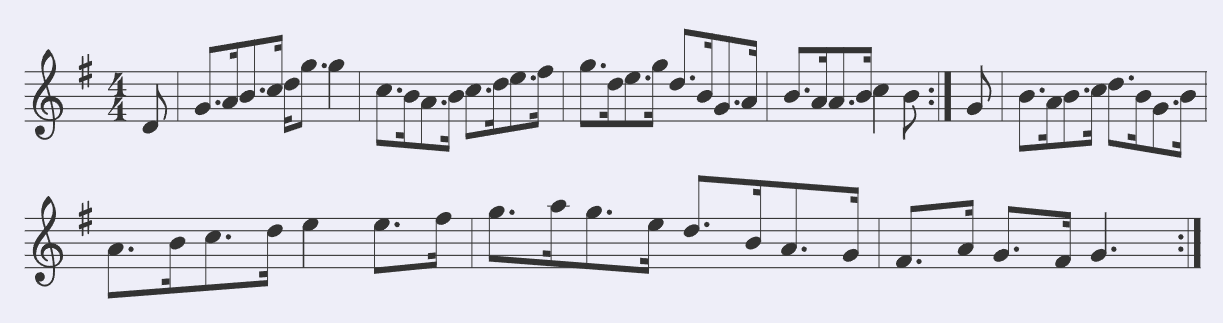